In [9]:
!pip -q install pywavelets opencv-python-headless


In [10]:
import cv2, numpy as np, pywt

def _to_gray(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
    return g.astype(np.float32)

def embed_dwt(cover_bgr, wm_gray, alpha=0.04, wavelet='haar'):
    cover = _to_gray(cover_bgr)

    # DWT of cover
    LL, (LH, HL, HH) = pywt.dwt2(cover, wavelet)

    # Resize watermark to exactly match LL's shape
    wm = cv2.resize(_to_gray(wm_gray), (LL.shape[1], LL.shape[0]))

    # Embed watermark in LL
    LLw = LL + alpha * wm
    watermarked = pywt.idwt2((LLw, (LH, HL, HH)), wavelet)
    return np.clip(watermarked, 0, 255).astype(np.uint8)


def extract_dwt(wm_bgr, cover_bgr, alpha=0.04, wavelet='haar'):
    wm_img = _to_gray(wm_bgr)
    cover = _to_gray(cover_bgr)
    LLw, _ = pywt.dwt2(wm_img, wavelet)
    LLc, _ = pywt.dwt2(cover,  wavelet)
    wm_rec = (LLw - LLc) / alpha
    return np.clip(wm_rec, 0, 255).astype(np.uint8)


In [11]:
from google.colab import files
uploaded = files.upload()


Saving cover.jpeg to cover (2).jpeg
Saving logo.png to logo (1).png


In [12]:
import cv2
import numpy as np

cover_path = "cover.jpeg"
wm_path    = "logo.png"

cover_bgr = cv2.imread(cover_path, cv2.IMREAD_COLOR)
wm_bgr    = cv2.imread(wm_path,    cv2.IMREAD_UNCHANGED)

if cover_bgr is None or wm_bgr is None:
    print(f"Error: Could not load images. Check if '{cover_path}' and '{wm_path}' exist and are valid image files.")
else:
    if wm_bgr.ndim == 3 and wm_bgr.shape[2] == 4:
        wm_bgr = cv2.cvtColor(wm_bgr, cv2.COLOR_BGRA2BGR)


    def visible_watermark(cover, logo, opacity=0.3, angle=45):
        # Calculate the aspect ratio of the logo
        logo_aspect_ratio = logo.shape[1] / logo.shape[0]

        # Determine a smaller size for the tiled watermark (e.g., 1/10th of the cover height)
        small_logo_height = cover.shape[0] // 10
        small_logo_width = int(small_logo_height * logo_aspect_ratio)

        # Resize the logo to the smaller size
        logo_small = cv2.resize(logo, (small_logo_width, small_logo_height))

        # Rotate the small logo
        (h, w) = logo_small.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_logo = cv2.warpAffine(logo_small, M, (w, h), borderValue=(0,0,0))


        # Create a tiled watermark image with the same size as the cover
        tiled_watermark = np.zeros_like(cover)

        # Tile the rotated logo across the cover
        for y in range(0, cover.shape[0], rotated_logo.shape[0]):
            for x in range(0, cover.shape[1], rotated_logo.shape[1]):
                # Calculate the region of interest in the tiled watermark
                roi_y1 = y
                roi_y2 = min(y + rotated_logo.shape[0], cover.shape[0])
                roi_x1 = x
                roi_x2 = min(x + rotated_logo.shape[1], cover.shape[1])

                # Calculate the region of interest in the rotated logo
                logo_roi_y2 = roi_y2 - roi_y1
                logo_roi_x2 = roi_x2 - roi_x1


                # Copy the rotated logo to the tiled watermark
                tiled_watermark[roi_y1:roi_y2, roi_x1:roi_x2] = rotated_logo[:logo_roi_y2, :logo_roi_x2]


        return cv2.addWeighted(cover, 1, tiled_watermark, opacity, 0)


    # Create visible watermark
    visible_wm = visible_watermark(cover_bgr, wm_bgr, opacity=0.1,angle=0) # Increased angle

    # Save result
    cv2.imwrite("visible_watermarked.png", visible_wm)

In [13]:
alpha = 0.04
wavelet = 'haar'

wm_img = embed_dwt(cover_bgr, wm_bgr, alpha=0.5, wavelet=wavelet)
cv2.imwrite("watermarked.png", wm_img)

ycrcb = cv2.cvtColor(cover_bgr, cv2.COLOR_BGR2YCrCb)

# Resize to match cover size
wm_resized = cv2.resize(wm_img, (cover_bgr.shape[1], cover_bgr.shape[0]))
ycrcb[...,0] = wm_resized

watermarked_color = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
cv2.imwrite("watermarked_color.png", watermarked_color)


True

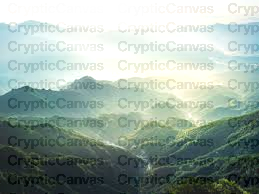

In [14]:
from IPython.display import Image, display

try:
  display(Image("visible_watermarked.png"))
except FileNotFoundError:
  print("Error: 'visible_watermarked.png' not found. Please ensure the previous cell was run successfully.")

### **WATERMARK DETECTION**

In [16]:
import cv2
import numpy as np
import pywt

def correlation_coefficient(img1, img2):
    """Compute normalized correlation between two images"""
    img1 = img1.astype(np.float32).flatten()
    img2 = img2.astype(np.float32).flatten()
    numerator = np.sum(img1 * img2)
    denominator = np.sqrt(np.sum(img1**2) * np.sum(img2**2))
    if denominator == 0:
        return 0
    return numerator / denominator

def extract_dwt(wm_bgr, cover_bgr, original_wm, alpha=0.04, wavelet='haar'):
    wm_img = cv2.cvtColor(wm_bgr, cv2.COLOR_BGR2GRAY) if wm_bgr.ndim == 3 else wm_bgr
    cover = cv2.cvtColor(cover_bgr, cv2.COLOR_BGR2GRAY) if cover_bgr.ndim == 3 else cover_bgr

    LLw, _ = pywt.dwt2(wm_img.astype(np.float32), wavelet)
    LLc, _ = pywt.dwt2(cover.astype(np.float32), wavelet)

    wm_rec = (LLw - LLc) / alpha
    wm_rec = np.clip(wm_rec, 0, 255).astype(np.uint8)

    # Resize original watermark for comparison
    original_resized = cv2.resize(original_wm, (wm_rec.shape[1], wm_rec.shape[0]))

    # Compute correlation
    corr = correlation_coefficient(wm_rec, original_resized)
    print(f"Correlation (DWT): {corr:.4f}")

    if corr > 0.5:
        print("Watermark detected!")
    else:
        print("Watermark not detected!")

    cv2.imwrite("extracted_logo.png", wm_rec)
    return wm_rec


Please upload the following images:
1. Cover image (original)
2. Watermarked image
3. Watermark/logo image


Saving cover.jpeg to cover (3).jpeg
Saving logo.png to logo (2).png
Saving watermarked.png to watermarked (1).png

Using files:
Cover: cover (1).jpeg
Watermarked: watermarked (1).png
Watermark: logo (2).png
Correlation (DWT): 0.7666
Watermark detected!


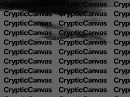

In [18]:
!pip -q install pywavelets opencv-python-headless

import cv2
import numpy as np
import pywt
from google.colab import files
from IPython.display import display, Image
import os


def _to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) if img.ndim==3 else img.astype(np.float32)

# --- Normalized correlation ---
def correlation_coefficient(img1, img2):
    img1 = img1.astype(np.float32).flatten()
    img2 = img2.astype(np.float32).flatten()
    numerator = np.sum(img1 * img2)
    denominator = np.sqrt(np.sum(img1**2) * np.sum(img2**2))
    return numerator / denominator if denominator != 0 else 0

# --- DWT Watermark Extraction & Detection ---
def detect_watermark_dwt(watermarked_path, cover_path, wm_path, alpha=0.5, wavelet='haar', threshold=0.5):
    # Load images
    watermarked = cv2.imread(watermarked_path)
    cover = cv2.imread(cover_path)
    original_wm = cv2.imread(wm_path)

    if watermarked is None:
        raise FileNotFoundError(f"Watermarked image not found: {watermarked_path}")
    if cover is None:
        raise FileNotFoundError(f"Cover image not found: {cover_path}")
    if original_wm is None:
        raise FileNotFoundError(f"Original watermark not found: {wm_path}")

    # Handle alpha channel for watermark
    if original_wm.ndim == 3 and original_wm.shape[2] == 4:
        original_wm = cv2.cvtColor(original_wm, cv2.COLOR_BGRA2BGR)

    # Convert to grayscale
    wm_img = _to_gray(watermarked)
    cover_gray = _to_gray(cover)

    # DWT LL-band extraction
    LL_wm, _ = pywt.dwt2(wm_img, wavelet)
    LL_cover, _ = pywt.dwt2(cover_gray, wavelet)

    # Extract watermark estimate
    wm_rec = (LL_wm - LL_cover) / alpha
    wm_rec = np.clip(wm_rec, 0, 255).astype(np.uint8)

    # Resize original watermark for comparison
    original_resized = cv2.resize(_to_gray(original_wm), (wm_rec.shape[1], wm_rec.shape[0]))

    # Compute correlation
    corr = correlation_coefficient(wm_rec, original_resized)
    print(f"Correlation (DWT): {corr:.4f}")

    if corr > threshold:
        print("Watermark detected!")
    else:
        print("Watermark not detected!")

    cv2.imwrite("extracted_logo.png", wm_rec)
    display(Image("extracted_logo.png"))

print("Please upload the following images:")
print("1. Cover image (original)")
print("2. Watermarked image")
print("3. Watermark/logo image")

uploaded = files.upload()

files_in_dir = os.listdir()
cover_path = next(f for f in files_in_dir if "cover" in f.lower())
watermarked_path = next(f for f in files_in_dir if "watermarked" in f.lower())
wm_path = next(f for f in files_in_dir if "logo" in f.lower())

print("\nUsing files:")
print("Cover:", cover_path)
print("Watermarked:", watermarked_path)
print("Watermark:", wm_path)

detect_watermark_dwt(watermarked_path, cover_path, wm_path, alpha=0.5, wavelet='haar', threshold=0.5)
